In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
import os, sys
sys.path.append('../../scripts/')
import numpy as np
import matplotlib.pyplot as plt
import rasterio, rasterio.plot
import xarray as xr
import rioxarray as rxr
from tqdm import tqdm
import pandas as pd
import time, datetime
import geopandas as gpd
import loadpaths
import land_cover_analysis as lca
import land_cover_visualisation as lcv
import land_cover_models as lcm
from torch.utils.data import TensorDataset, DataLoader

path_dict = loadpaths.loadpaths()

# Finding ideal padding size for patches

In [ ]:
LCU = lcm.load_model(filename='LCU_2023-01-23-2018.data')
LCU.model_name

In [ ]:
pred_no_padding = lcm.prediction_one_tile(model=LCU, tilepath=list_tiff_files[0], padding=0)
print(f'Shape of prediction: {pred_no_padding[2]}')
plt.imshow(pred_no_padding[0].values)

In [ ]:
pred_padding = lcm.prediction_one_tile(model=LCU, tilepath=list_tiff_files[0], padding=42, verbose=2)
print(f'Shape of prediction: {pred_padding[2]}')
plt.imshow(pred_padding[0].values)

In [ ]:
tmp_results = lcm.tile_prediction_wrapper(model=LCU, save_shp=False, save_raster=False, 
                            dir_im='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/',
                            dir_mask_eval='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/',
                            save_folder=None, dissolve_small_pols=False, 
                            area_threshold=0, skip_factor=16,
                            subsample_tiles_for_testing=True)

In [ ]:
tmp_results_padding = lcm.tile_prediction_wrapper(model=LCU, save_shp=False, save_raster=False, 
                            dir_im='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/12.5cm Aerial Photo/',
                            dir_mask_eval='/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/117574_20221122/tile_masks_2022/',
                            save_folder=None, dissolve_small_pols=False, 
                            area_threshold=0, skip_factor=16, padding=42, 
                            subsample_tiles_for_testing=True)

In [ ]:
tmp_results[0], tmp_results_padding[0]

Text(0, 0.5, 'remainder')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


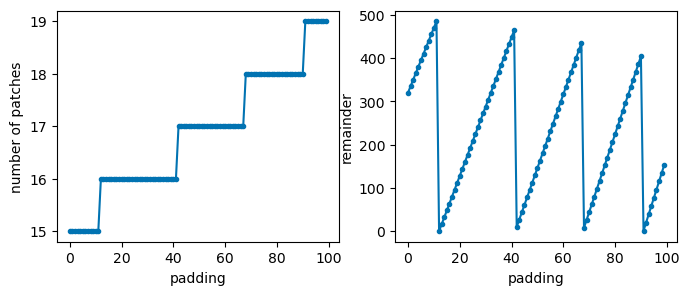

In [6]:
def tmp_npatches(overlap):
    return int(np.floor(8000 / (512 - overlap)))

def tmp_remain(pad):
    return 8000 - (512 - pad) * tmp_npatches(pad)

xarr = np.arange(100)
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].plot(xarr, [tmp_npatches(x) for x in xarr], '.-')
ax[0].set_xlabel('padding')
ax[0].set_ylabel('number of patches')

ax[1].plot(xarr, [tmp_remain(x) for x in xarr], '.-')
ax[1].set_xlabel('padding')
ax[1].set_ylabel('remainder')

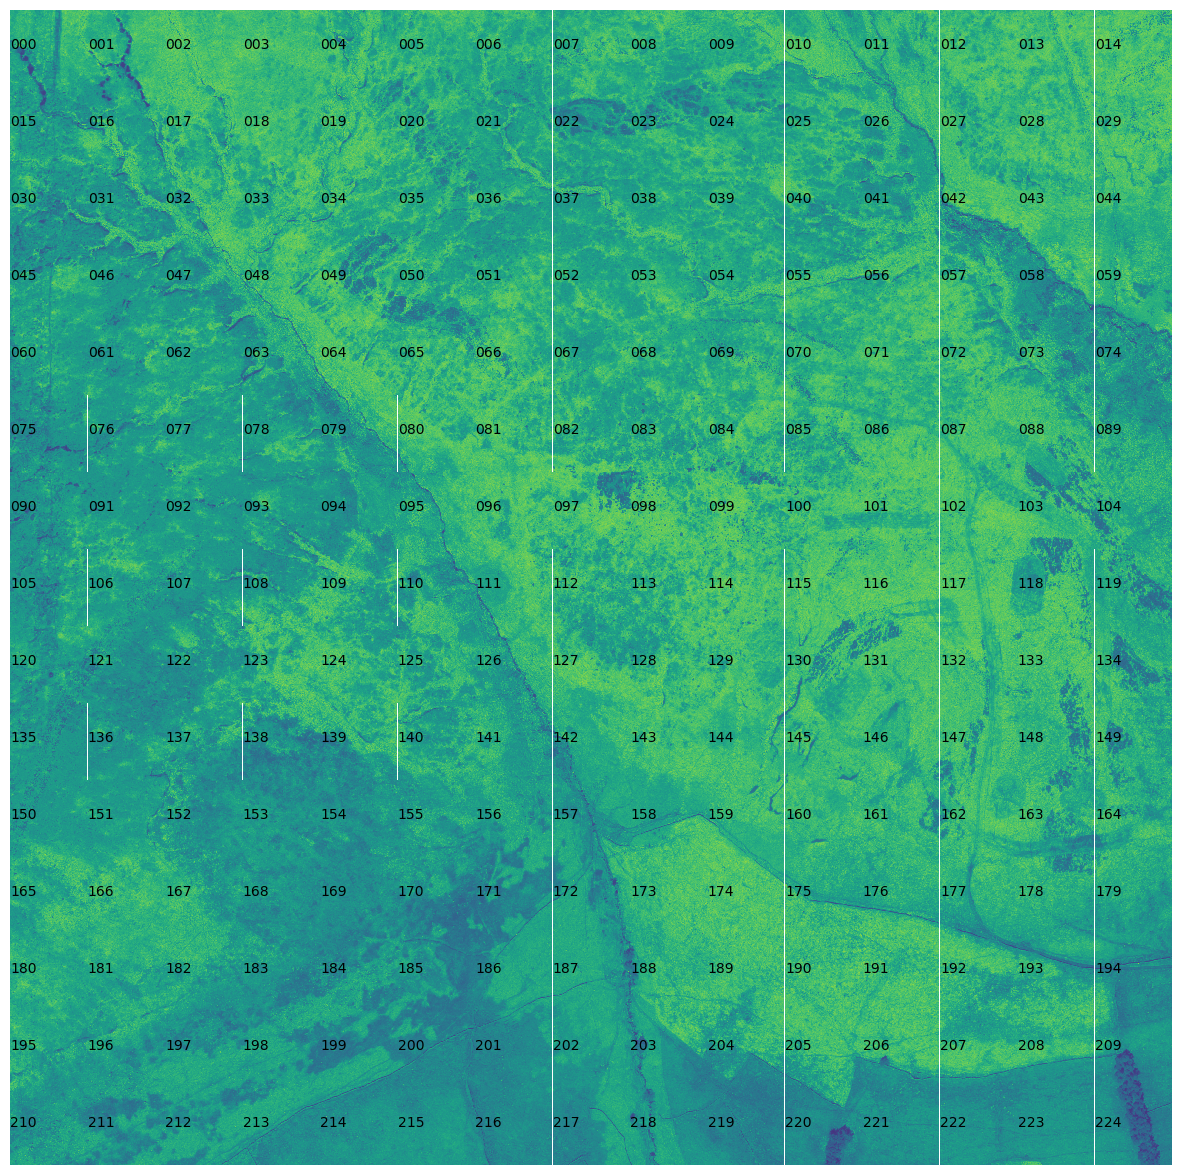

In [7]:
dict_npys = {}
for ii in range(225):
    tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/images/SE0800_patch{str(ii).zfill(3)}.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/evaluation_tiles/masks_2022/SE0800_patch{str(ii).zfill(3)}_lc_2022_mask.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/images/SK2969_patch{str(ii).zfill(3)}.npy' 
    # tmp_path = f'/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/masks/SK0560_patch{str(ii).zfill(3)}_lc_80s_mask.npy' 
    dict_npys[ii] = np.load(tmp_path, 'r')

fig, ax = plt.subplots(15, 15, figsize=(15, 15), gridspec_kw={'wspace': 0, 'hspace': 0})

icol, irow = 0, 0
for ii, im in dict_npys.items():
    curr_ax = ax[irow, icol]
    tmp = curr_ax.imshow(im[0, :, :], interpolation='none', vmin=0 ,vmax=255)
    # tmp = curr_ax.imshow(im, interpolation='none', vmin=0 ,vmax=5)
    curr_ax.text(s=str(ii).zfill(3), x=im.shape[0] / 2, y=im.shape[1] / 2)
    lcv.naked(curr_ax)
    icol += 1 
    if icol == 15:
        irow += 1
        icol =0 
    
# plt.colorbar(tmp)

# Unsupervised segmentation of RGB images

(3, 8000, 8000) <class 'numpy.ndarray'>


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


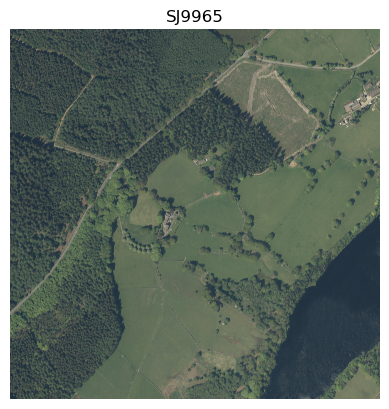

In [8]:
## Load image:

example_tiff_file = 'SJ9965.tif'
example_tiff_path = os.path.join(path_dict['image_path'], example_tiff_file)
example_tiff_path = '/home/tplas/data/gis/most recent APGB 12.5cm aerial/CDE_training_tiles/tiles/SK2391.tif'
ex_tile = lca.load_tiff(tiff_file_path=example_tiff_path, datatype='da')
lcv.plot_image_simple(im=ex_tile, name_file=example_tiff_file)

In [9]:
ex_tile_np = ex_tile.values
ex_tile_np = np.swapaxes(ex_tile_np, 0, 1)
ex_tile_np = np.swapaxes(ex_tile_np, 1, 2)
ex_tile_np = ex_tile_np / 255
ex_tile_np = ex_tile_np[::4, ::4, :]

In [10]:
import skimage.segmentation as skseg

In [11]:
segments_fz = skseg.felzenszwalb(ex_tile_np, scale=350, sigma=0.5, min_size=1000)

(-0.5, 1999.5, 1999.5, -0.5)

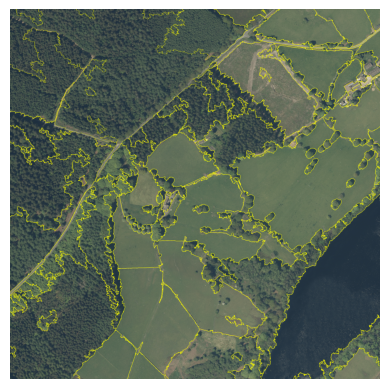

In [12]:
plt.imshow(skseg.mark_boundaries(ex_tile_np, segments_fz))
plt.axis('off')

## Create patch grids of set of tiles
- Load tile outlines 
- Create patch grids (in polygons) based on patch size settings for CNN 
- Export with extra columns

In [ ]:
tile_outlines = lca.load_pols('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/evaluation_sample_50tiles.shp')

In [ ]:
# tmp = lca.create_patch_grid_from_tile_outline(tile_outline_pol=tile_outlines.iloc[0]['geometry'])
tmp = lca.create_patch_grid_from_tile_outline(tile_row=tile_outlines.iloc[0], select_9_random_patches=True)

In [ ]:
tmp.plot(column='RAND_ANNOT')

In [ ]:
df_patch_grid = lca.create_patch_grid_for_df_outlines(df_tile_outlines=tile_outlines)
assert len(tile_outlines) == 50 
assert df_patch_grid['RAND_ANNOT'].sum() == 450 
assert df_patch_grid['SEL_ANNOT'].sum() == 0 

In [ ]:
# df_patch_grid.to_file('/home/tplas/repos/cnn-land-cover/content/evaluation_sample_50tiles/eval_patch_grid_annotations/eval_patch_grid_annotations.shp')